In [2]:
include("includes.jl");

### Setup

In [88]:
@everywhere measurements, measurements_mask = load_experiments()
@everywhere kid_id = 26 # 1 3 19 20 26 28
@everywhere n_measurements = length(measurements[kid_id, measurements_mask[kid_id,:] .!= 0])

@everywhere prior = Normal(10,1)

@everywhere Θ₀ = [5*pi/180, 0]
@everywhere function dΘ(g)
    Θ -> [Θ[2], -g*sin(Θ[1])/8]
end

@everywhere grid = [0; measurements[kid_id,:][measurements_mask[kid_id,:] .!= 0]]

@everywhere loglikelihood = (n, g) ->
    let
        if n == 0
            return 0
        end
        
        e = rk4s(dΘ(g[1]), Θ₀, grid[1:n+1], 0.01)[2:end,1]
        s2 = 1e-3
    
        (sum(e.^2)/(2*s2), e[end]/2)
    end

full_loglikelihood = g -> loglikelihood(n_measurements, g[1])[1];

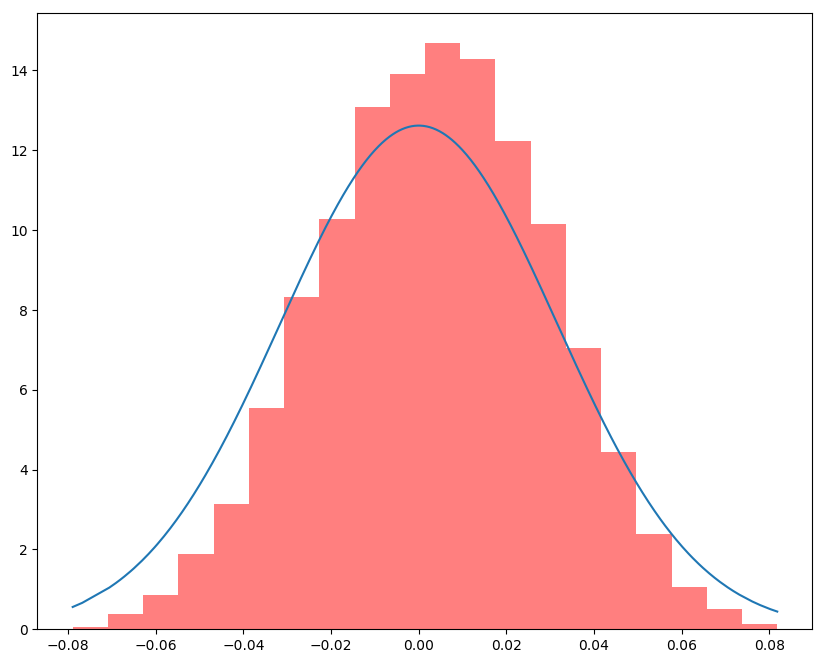

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0e7973c910>

In [89]:
n=1000
e = .180 # 180ms is the typical human reaction delay to images
#@article{wardle1998time,
#  title={The time delay in human vision},
#  author={Wardle, DA},
#  journal={The physics teacher},
#  volume={36},
#  number={7},
#  pages={442--444},
#  year={1998},
#  publisher={AAPT}
#}

X = zeros(n, n_measurements-1)

for i=1:n
    X[i,:] = rk4s(dΘ(9.86), Θ₀, grid[1:n_measurements] + e*randn(n_measurements), 0.01)[2:end,1]
end

plt[:hist](X[:], bins=20, normed=true, alpha=0.5,
         histtype="stepfilled", color="red");

Y = sort(X[:])
s2 = 1e-3
plot(Y, exp.(-Y.^2/(2*s2))/sqrt(2*pi*s2) )

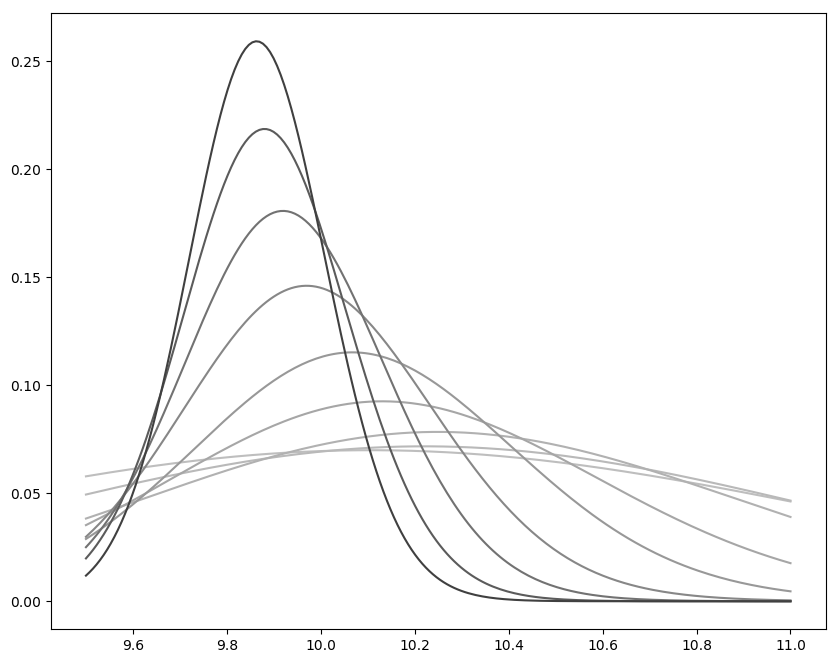

In [90]:
mesh = linspace(9.5,11,200)
for n=1:n_measurements
    lhood = (g -> -loglikelihood(n, g)[1] + Distributions.logpdf(prior, g)).(mesh)
    elhood = exp.(lhood)
    elhood = elhood / sum(elhood) / sqrt(2*pi*1e-3)
    c = 0.75 - (n * 1.0 / n_measurements)^2/2
    plot(mesh, elhood, color=[c,c,c])
end

### Metropolis Hastings with gaussian noise

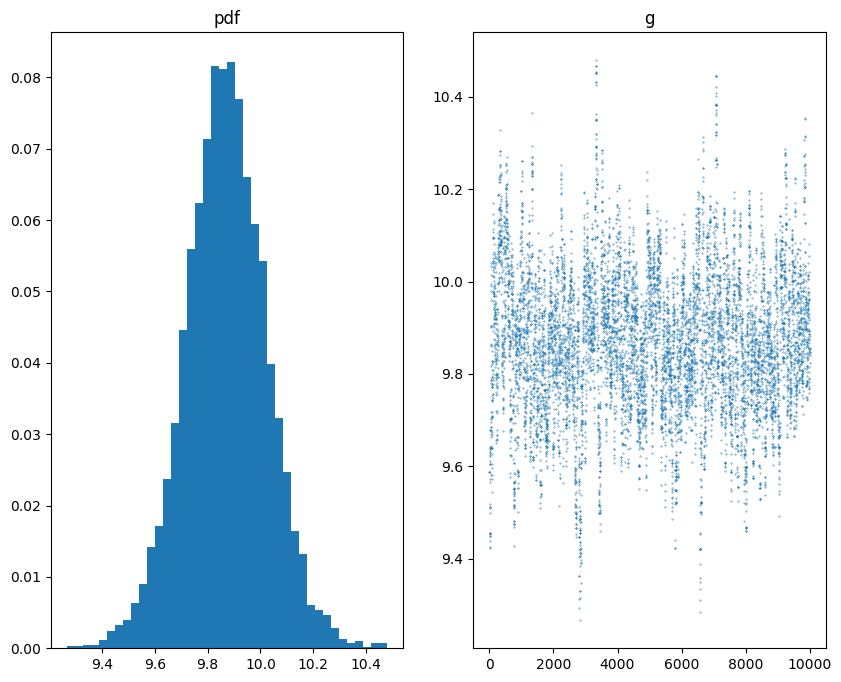

8940 / 10000 of the sampled particles were accepted (89.0%)
        
The expectation estimation is of 9.86961641767083


In [92]:
function GaussianMetropolisHastings(K, prior, ϕ, γ, warmup)
    x₀ = rand(prior, 1)
    
    X = zeros(K-warmup, length(x₀))
    W = zeros(K-warmup)
    accepted = 0
    
    w = MvNormal(γ^2*eye(length(x₀)))
    x = x₀
    ϕₓ = ϕ(x)
    
    for k=1:K
        y = x + rand(w)
        ϕₙ = ϕ(y)
        if rand() < min(1, (pdf(prior, y[1])/pdf(prior, x[1]))*exp(ϕₓ-ϕₙ))
            x = y
            ϕₓ = ϕₙ
            if k > warmup
                accepted += 1
            end
        end
    
        if k > warmup
            W[k-warmup] = ϕₙ * pdf(prior, x[1])
            X[k-warmup,:] = x
        end
    end
    X, exp.(-W), accepted
end

out = GaussianMetropolisHastings(10_500, prior, full_loglikelihood, 0.05, 500)
plotMCMC(out)

### Sequential Monte Carlo with gaussian noise

In [120]:
function noop(n,W,X)
end

function GaussianSequentialMonteCarlo(X₀, p, prior, ll; μ=0.1, callback=noop)
    # initialization
    N,d = size(X₀)
    w = MvNormal(μ^2 * eye(d))

    X = SharedArray{Float64}(X₀)
    dX = SharedArray{Float64,2}(X₀)
    
    alphas = SharedArray{Float64}(N)
    W = SharedArray{Float64}(N)
    
    acceptance_rate = ones(p) ./ N
    ess = zeros(p)
    maxweights = zeros(p)
    minweights = zeros(p)
    
    # initialize
    s = @parallel (+) for i=1:N
        W[i] = exp(-ll(1, X[i,:])[1])
    end
    @sync @parallel for i=1:N
        W[i] /= s
    end
    
    for n = 1:p
        # update
        copy!(dX, rand(w, N)')
        rand!(alphas)
        
        @sync @parallel for i=1:N
            W[i] = log(W[i])
        end
        
        acceptance_rate[n] *= @parallel (+) for i=1:N
            accepted = 0
            
            xₙ₋₁ = X[i,:]
            xₙ = xₙ₋₁ + dX[i,:]

            wₙ,dwₙ= ll(n, xₙ)
            wₙ₋₁,dwₙ₋₁ = ll(n, xₙ₋₁)
            
            if alphas[i] < min(1, exp(-wₙ + wₙ₋₁))
                X[i,:] = xₙ
                accepted += 1
            end
            W[i] = -dwₙ₋₁
            
            accepted
        end

        # normalize weights
        s = @parallel (+) for i=1:N
            W[i] = exp(W[i])
        end
        
        @sync @parallel for i=1:N
            W[i] /= s
        end
        
        minweights[n] = minimum(W)
        maxweights[n] = maximum(W)
        
        # resample
        ess[n] = 1 / vecdot(W,W)
        if ess[n] < N/2            
            perm = rand(Categorical(W[:]), N)
            @sync @parallel for i=1:N
                X[i,:] = X[perm[i], :]
                W[i] = 1/N
            end 
        end
        
        callback(n,W,X)
    end
    
    W,X,acceptance_rate,ess,minweights,maxweights
end

GaussianSequentialMonteCarlo (generic function with 1 method)

In [124]:
function mksaveprogress(directory,name)
    function saveprogress(n,w,x)
        writedlm("$directory/$name/$n", [w, x])
    end
    
    if !isdir(directory)
        mkdir(directory)
    end
    
    if !isdir("$directory/$name")
        mkdir("$directory/$name")
    end
    
    return saveprogress
end

function mkplotprogress(ll,n_repeat,n_measurements)
    function plotprogress(n,w,x)
        ax = subplot(n_measurements,n_repeat,n) 
        PyPlot.plt[:hist](x, 40, weights=w)
        mesh = linspace(max(9.5,minimum(x)), min(11, maximum(x)), 200)
        posterior = exp.((g -> -ll(n,g)[1] + Distributions.logpdf(prior, g)).(mesh))
        posterior /= sum(posterior)
        plot(mesh, posterior)

        ax[:set_yticklabels]([])
        ax[:set_xticklabels]([])
    end
    return plotprogress
end

mkplotprogress (generic function with 1 method)

In [17]:
repeat = 10
modulo_llhood = (n, g) -> loglikelihood(div(n - (n-1)%repeat, repeat)+1, g)

for N in [2000, 5000, 10_000, 25_000, 50_000, 75_000]
    X₀ = reshape(rand(prior, N), N, 1)
    progress = mksaveprogress("results", "N_$(N)_kid_$(kid_id)_MCMC_$(repeat)")
    print("starting N=$N")
    outs = GaussianSequentialMonteCarlo(X₀, repeat*n_measurements, prior, modulo_llhood, μ=0.5, callback=progress);
    println("done")
end

starting N=2000done
starting N=5000done
starting N=10000done
starting N=25000done
starting N=50000done
starting N=75000done


In [13]:
progress = mksaveprogress("results", "100")
outs = GaussianSequentialMonteCarlo(X₀, repeat*n_measurements, prior, modulo_llhood, μ=0.5, callback=progress);

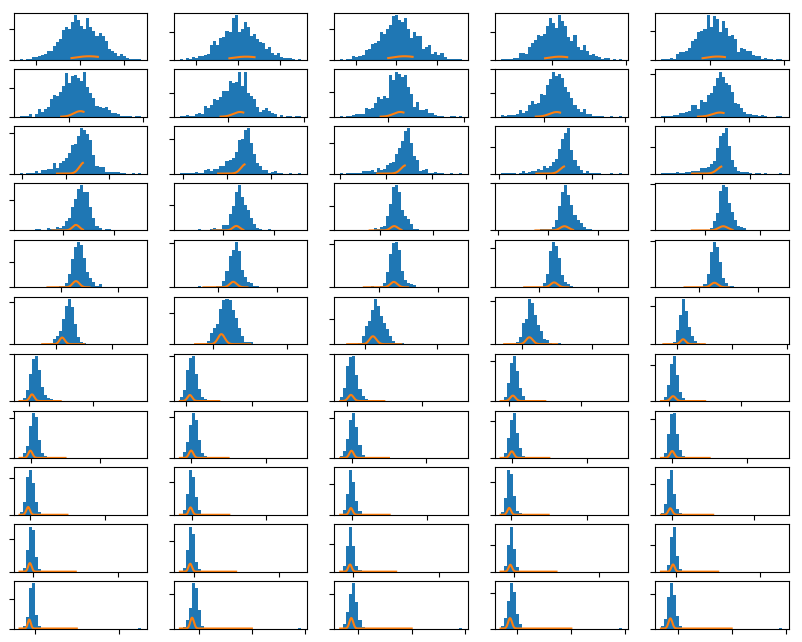

In [158]:
N=1000
repeat = 5
modulo_llhood = (n, g) -> loglikelihood(div(n - (n-1)%repeat, repeat)+1, g)

plotprogress = mkplotprogress(modulo_llhood, repeat, n_measurements)

X₀ = reshape(rand(prior, N), N, 1)
outs = GaussianSequentialMonteCarlo(X₀, repeat*n_measurements, prior, modulo_llhood, μ=0.5, callback=plotprogress);

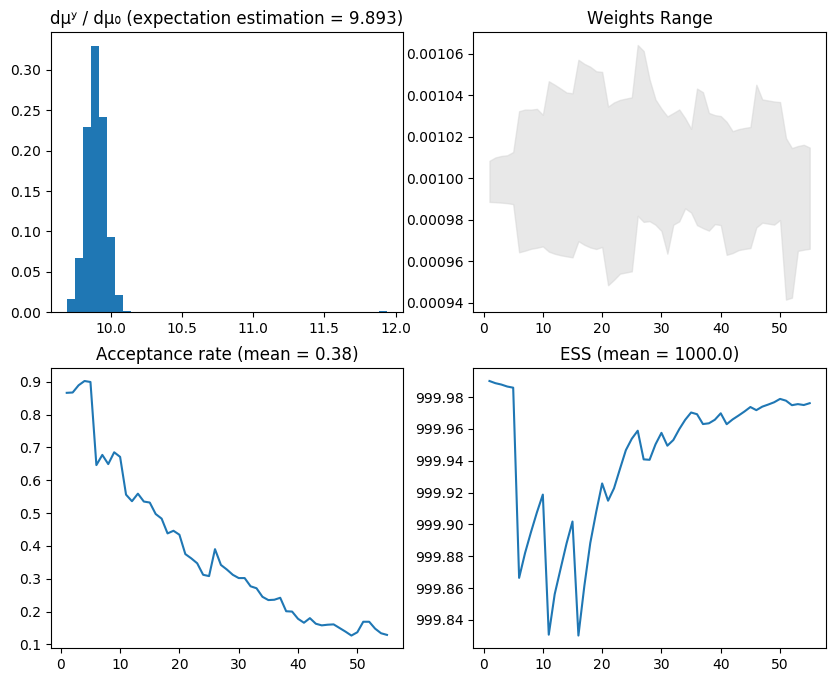

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f41b4563910>

In [159]:

function plotSMC(output)
    W,X,A,ESS,d,u = output
    
    t = 1:length(A)
    
    subplot(221)
    title("dμʸ / dμ₀ (expectation estimation = $(round(vecdot(X,W)*1000)/1000))")
    PyPlot.plt[:hist](X, 40, weights=W)
    
    subplot(222)
    title("Weights Range")
    fill_between(t, d, u, alpha=0.5, color="lightgrey")
    
    subplot(223)
    title("Acceptance rate (mean = $(round(mean(A) * 100)/100))")
    plot(t, A)
    
    subplot(224)
    title("ESS (mean = $(round(mean(ESS))))")
    plot(t, ESS)
end

plotSMC(outs)

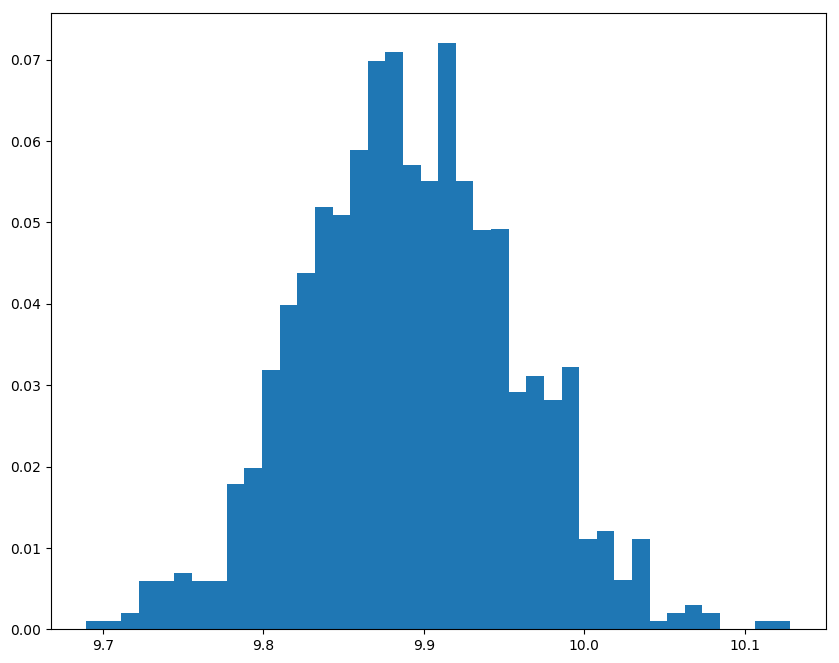

In [165]:
W,X,A,ESS,d,u = outs

perm=sortperm(X[:,1])
X=X[perm]
W=W[perm]

c=0.0001
pred=(cumsum(W) .>= c) .& (cumsum(W) .<= 1-c)

PyPlot.plt[:hist](X[pred], 40, weights=W[pred]);